# Cell-type deconvolution using Tangram

In this tutorial, we show how to leverage Squidpy's `squidpy.im.ImageContainer` for cell-type deconvolution tasks.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell-type annotation across technologies. Information on the number of nuclei under each spot can help cell-type deconvolution methods.
**Tangram** (<cite data-cite="tangram">Biancalani et al. (2020)</cite>, [code](https://github.com/broadinstitute/Tangram)) is a cell-type deconvolution method that enables mapping of cell-types to single nuclei under each spot. We will show how to leverage the image container segmentation capabilities, together with Tangram, to map cell types of the mouse cortex from sc-RNA-seq data to Visium data.

First, let's import some libraries.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%load_ext lab_black

scanpy==1.7.2 anndata==0.7.5 umap==0.5.1 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.24.1 statsmodels==0.12.2
squidpy==1.0.0


We will load the public data available in Squidpy.

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

Here, we subset the crop of the mouse brain to only contain clusters of the brain cortex. The pre-processed single cell dataset was taken from <cite data-cite="tasic2018shared">Tasic et al. (2018)</cite> and pre-processed with standard scanpy functions. To start off, let's visualize both spatial and single-cell datasets.

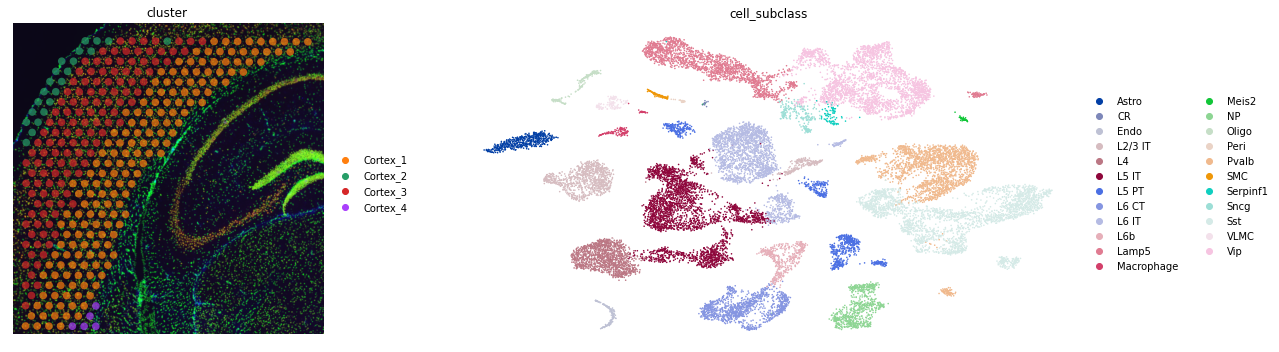

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

## Nuclei segmentation and segmentation features
As mentioned before, we are interested in segmenting single nuclei under each spot in the Visium dataset. Squidpy makes it possible with two lines of python code:
- `squidpy.im.process` applies smoothing as a pre-processing step
- `squidpy.im.segment` computes segmentation masks with watershed algorithm

In [4]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

Let's visualize the results for an inset

Text(0.5, 1.0, 'Nucleous segmentation')

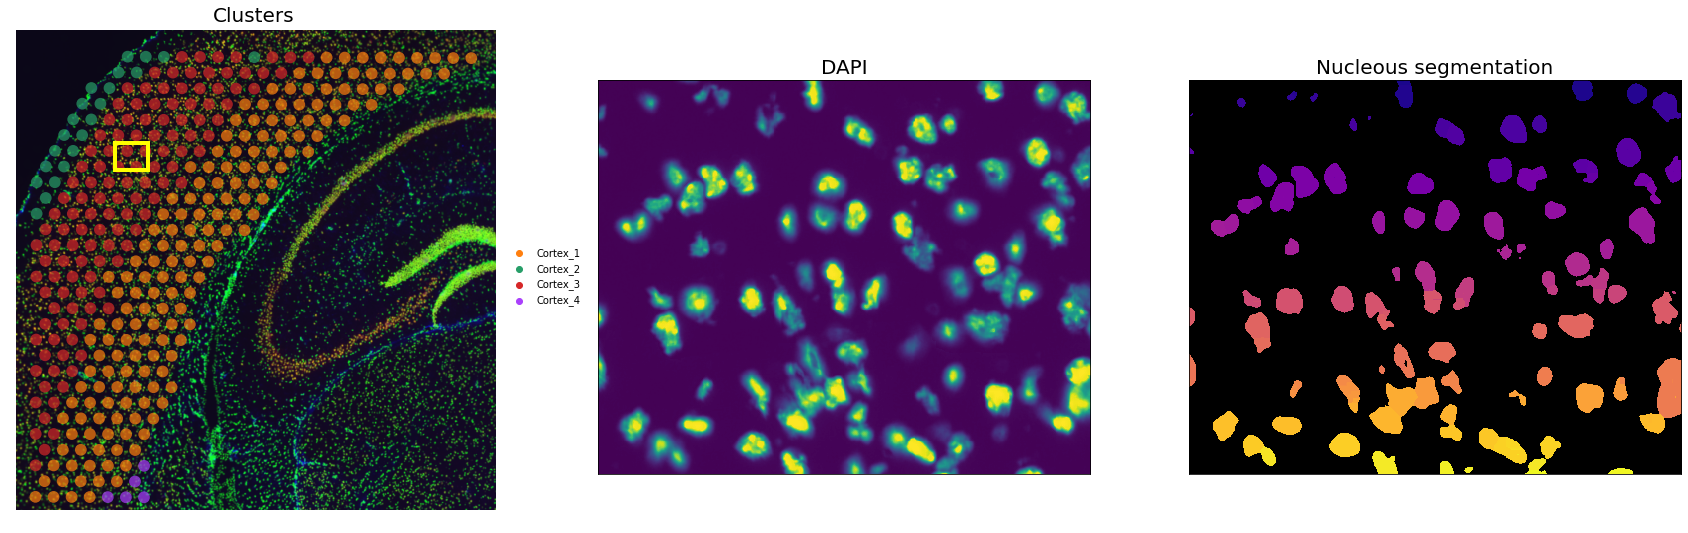

In [5]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0] / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20})

We can appreciate that despite some false positive, the nuclei segmentation worked well.

We then need to extract some image features useful for the deconvolution task downstream. Specifically, we will need:
- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.

It will become clear later how we will be using them.

In [6]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

We can visualize the total number of objects under each spot with scanpy.

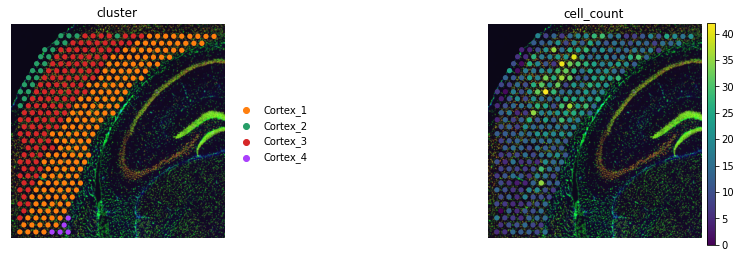

In [7]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the intersection of the highly variable genes.

In [8]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass")

In [9]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_st.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

1436

In [10]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1435 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on the GPU. However, it's also possible to train it on the CPU, it will just be slower.

In [11]:
ad_map = tg.map_cells_to_space(
            adata_sc, 
            adata_st,  
            mode='constrained', 
            target_count=adata_st.obs.cell_count.sum(),
            density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(), 
            lambda_d=1, 
            learning_rate=0.01, 
            num_epochs=6000,
            device="cuda:0")

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1435 genes in constrained mode...


Score: 0.670, KL reg: 0.120, Count reg: 5774.681, Lambda f reg: 4477.364
Score: 0.662, KL reg: 0.022, Count reg: 1224.670, Lambda f reg: 3889.369
Score: 0.678, KL reg: 0.018, Count reg: 2.146, Lambda f reg: 3308.227
Score: 0.695, KL reg: 0.016, Count reg: 2.224, Lambda f reg: 2976.172
Score: 0.709, KL reg: 0.015, Count reg: 7.156, Lambda f reg: 2597.831
Score: 0.719, KL reg: 0.014, Count reg: 0.542, Lambda f reg: 2217.611
Score: 0.725, KL reg: 0.014, Count reg: 1.227, Lambda f reg: 1862.036
Score: 0.727, KL reg: 0.014, Count reg: 1.125, Lambda f reg: 1550.239
Score: 0.729, KL reg: 0.014, Count reg: 1.957, Lambda f reg: 1288.127
Score: 0.729, KL reg: 0.014, Count reg: 0.227, Lambda f reg: 1077.521
Score: 0.730, KL reg: 0.014, Count reg: 2.219, Lambda f reg: 910.645
Score: 0.730, KL reg: 0.014, Count reg: 0.665, Lambda f reg: 781.688
Score: 0.730, KL reg: 0.014, Count reg: 0.785, Lambda f reg: 677.917
Score: 0.730, KL reg: 0.014, Count reg: 0.011, Lambda f reg: 595.166
Score: 0.730, KL r

INFO:root:Saving results..


In [12]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass", threshold=0.5)

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


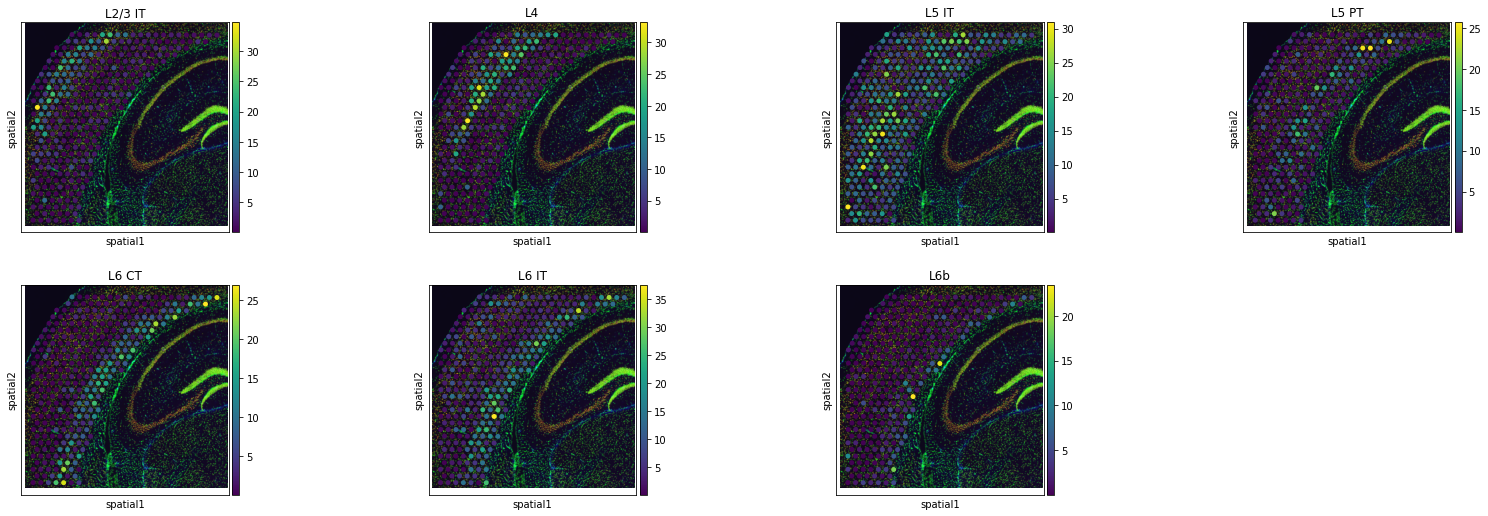

In [13]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm['tangram_ct_pred']], axis=1)

sc.pl.spatial(
    adata_st,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

And here comes the key part, where we will use the results of the previous deconvolution steps. Previously, we computed the absolute numbers of unique segmentation objects under each spot, together with their centroids. Let's extract them in the right format useful for Tangram.

In the resulting dataframe, each row represents a single segmentation object (therefore a single nuclei). We also have the image coordinates as well as the unique centroid ID, which is a string that contains both the spot ID and a numerical index.

In [14]:
centroids = adata_st.obsm["image_features"][["segmentation_centroid"]].copy()
centroids["centroids_idx"] = [
    np.array([f"{k}_{j}" for j in np.arange(i)], dtype="object")
    for k, i in zip(
        adata_st.obs.index.values,
        adata_st.obs.cell_count.values,
    )
]
centroids_idx = centroids.explode("centroids_idx")
centroids_coords = centroids.explode("segmentation_centroid")
segmentation_df = pd.DataFrame(
    centroids_coords["segmentation_centroid"].to_list(),
    columns=["y", "x"],
    index=centroids_coords.index,
)
segmentation_df["centroids"] = centroids_idx["centroids_idx"].values
segmentation_df.index.set_names("spot_idx", inplace=True)
segmentation_df.reset_index(
    drop=False,
    inplace=True,
)
segmentation_df

spot_idx            y            x              centroids
0     AAATGGCATGTCTTGT-1  5304.000000   731.000000   AAATGGCATGTCTTGT-1_0
1     AAATGGCATGTCTTGT-1  5323.118960   727.044256   AAATGGCATGTCTTGT-1_1
2     AAATGGCATGTCTTGT-1  5335.048316   716.818254   AAATGGCATGTCTTGT-1_2
3     AAATGGCATGTCTTGT-1  5333.475064   723.037138   AAATGGCATGTCTTGT-1_3
4     AAATGGCATGTCTTGT-1  5342.625256   566.636665   AAATGGCATGTCTTGT-1_4
...                  ...          ...          ...                    ...
5080  TTGTTAGCAAATTCGA-1  1735.311472  2800.246454  TTGTTAGCAAATTCGA-1_22
5081  TTGTTAGCAAATTCGA-1  1761.621120  2723.313599  TTGTTAGCAAATTCGA-1_23
5082  TTGTTAGCAAATTCGA-1  1762.928430  2731.843522  TTGTTAGCAAATTCGA-1_24
5083  TTGTTAGCAAATTCGA-1  1763.491123  2811.891481  TTGTTAGCAAATTCGA-1_25
5084  TTGTTAGCAAATTCGA-1  1768.000000  2776.790179  TTGTTAGCAAATTCGA-1_26

[5085 rows x 4 columns]

The following code is taken from the Tangram tutorial. Essentially we are mapping the cell types proportions computed before to single segmentation objects.

In [15]:
tg.count_cell_annotations(ad_map, adata_sc, adata_st,  
                          xs=adata_st.obsm["spatial"][:, 1], 
                          ys=adata_st.obsm["spatial"][:, 0],
                          centroids=centroids["centroids_idx"], 
                          cell_count=adata_st.obs.cell_count, 
                          annotation="cell_subclass", threshold=0.5,
                         )

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [16]:
adata_segment = tg.segment(segmentation_df, pd.unique(adata_sc.obs['cell_subclass']), adata_st)

The result is a dataframe with two columns: the unique segmentation object id, and the cell type mapped. We can merge it with the previous dataframe to obtain the coordinates, and obtain a new AnnData object which can then be used for visualization.

Note that the AnnData object does not contain counts, but only cell type annotations, as results of the Tangram mapping. 
Nevertheless, it's convenient to create such AnnData object for visualization purposes.

Below you can appreciate how each dot is now not a Visium spot anymore, but a single unique segmentation object, with the mapped cell type.

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

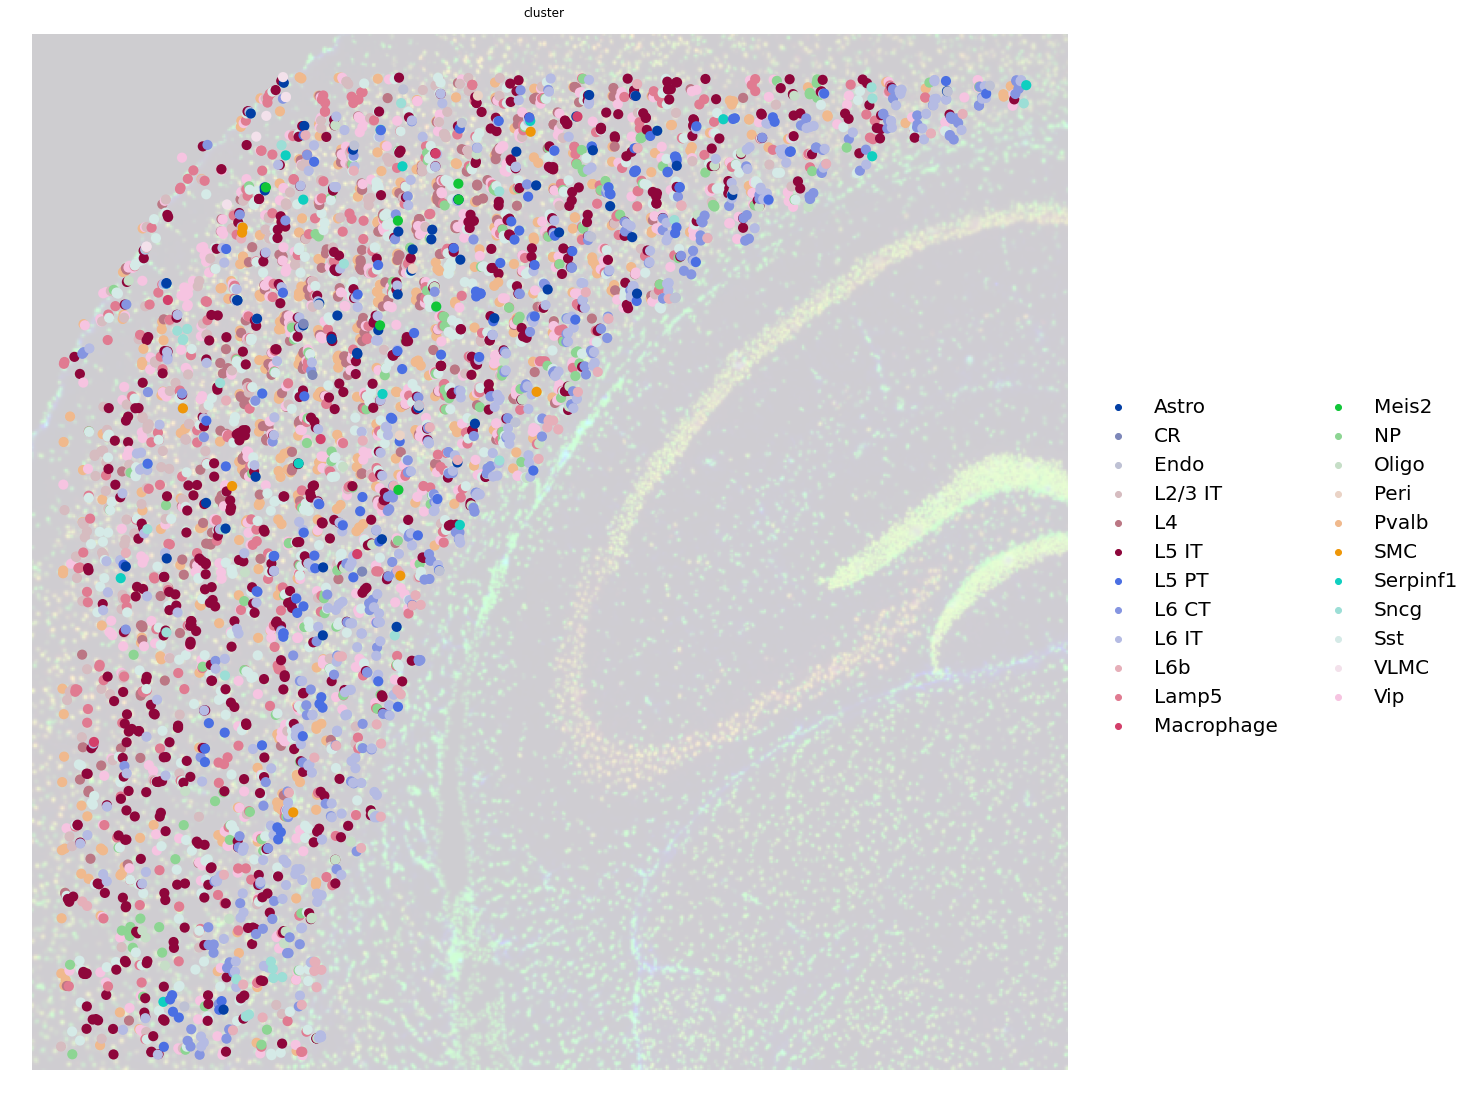

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)